# Difftest Results

Connect to results database:

In [1]:
import db
from db import *

hostname = "cc1"
db.init(hostname)

'mysql://cc1:3306/project_b'

## Overview

In [2]:
import pandas as pd

session = db.make_session()

TABLE_NAMES = ["CLSmith", "CLSmith w. cldrive", "GitHub", "CLgen"]
TABLES = [CLSmithResult, cldriveCLSmithResult, GitHubResult, CLgenResult]

data = [
    ("#. Programs", [session.query(t.program_id).group_by(t.program_id).count() for t in TABLES]),
    ("#. Testbeds", [session.query(t.testbed_id).group_by(t.testbed_id).count() for t in TABLES]),
    ("#. Params", [session.query(t.params_id).group_by(t.params_id).count() for t in TABLES]),
    ("#. Results", [session.query(t).count() for t in TABLES])
]
i, d = zip(*data)
overview = pd.DataFrame(list(d), index=i, columns=TABLE_NAMES)
overview

,CLSmith,CLSmith w. cldrive,GitHub,CLgen
#. Programs,10001,10001,9238,1000
#. Testbeds,6,5,5,5
#. Params,4,4,4,4
#. Results,200043,200020,178139,20000


# Experimental Setup

### TestBeds

A testbed is a combination of host platform and OpenCL device.

In [3]:
import sqlalchemy as sql

DEVICES = {  # shorthand device names
    "GeForce GTX 1080": "NVIDIA GTX 1080",
    "Intel(R) Xeon(R) CPU E5-2620 v4 @ 2.10GHz": "Intel E5-2620",
    "Olcgrind Simulator": "Oclgrind",
    "pthread-Intel(R) Xeon(R) CPU E5-2620 v4 @ 2.10GHz": "Intel E5-2620 (pocl)",
    "Intel(R) Core(TM) i5-4570 CPU @ 3.20GHz": "Intel i5-4570",
    'Intel(R) HD Graphics Haswell GT2 Desktop': 'Intel HD Haswell GT2',
}

DRIVERS = {
    "Oclgrind 16.10": "16.10",
}

PLATFORMS = {
    "Portable Computing Language": "POCL",
}

q = session.query(Testbed).order_by(sql.func.field(Testbed.devtype, 'GPU', 'CPU', 'Emulator'))

data = []
for testbed in q:
    data.append(
        (testbed.id, [
            testbed.host, DEVICES.get(testbed.device, testbed.device),
            DRIVERS.get(testbed.driver, testbed.driver), testbed.opencl, testbed.devtype] +
         [session.query(t.testbed).filter(t.testbed == testbed).count() for t in TABLES]))
i, d = zip(*data)
testbeds = pd.DataFrame(list(d), index=i, columns=["Operating System", "Device", "Driver", "OpenCL", "Device type"] + [f"#. {t}" for t in TABLE_NAMES])
testbeds

,Operating System,Device,Driver,OpenCL,Device type,#. CLSmith,#. CLSmith w. cldrive,#. GitHub,#. CLgen
12,Ubuntu 16.04 64bit,Intel E5-2620 (pocl),0.14,2.0,3,240024,240024,221712,24000
3,Ubuntu 16.04 64bit,NVIDIA GTX 1080,375.39,1.2,GPU,240024,240024,284682,24000
13,Ubuntu 16.04 64bit,Intel HD Haswell GT2,1.3,1.2,GPU,138,0,0,0
9,Ubuntu 16.04 64bit,Intel E5-2620,1.2.0.25,2.0,CPU,240024,240024,221712,24000
10,Ubuntu 16.04 64bit,Intel i5-4570,1.2.0.25,1.2,CPU,240024,240024,119016,24000
11,Ubuntu 16.04 64bit,Oclgrind Simulator,16.10,1.2,Emulator,240024,240024,221712,24000


In [4]:
# push LaTex to Overleaf
!cd ~/docs/paper-project_b/ && git pull --rebase
import os
data = []
for testbed in session.query(Testbed):
    data.append([
        PLATFORMS.get(testbed.platform, testbed.platform), testbed.device, DRIVERS.get(testbed.driver, testbed.driver),
        testbed.opencl, testbed.host, testbed.devtype])
table = pd.DataFrame(data, index=range(1, len(data)+1), columns=[
    "Platform", "Device", "Driver", "OpenCL", "Operating system", "Device type"])
with open(os.path.expanduser("~/docs/paper-project_b/build/tab/platforms.tex"), "w") as outfile:
    table.to_latex(buf=outfile)
!cd ~/docs/paper-project_b/build && git add . && git commit -m "auto: build/tab/platforms.tex" && git push
table

remote: Counting objects: 7, done
remote: Finding sources: 100% (4/4)
remote: Getting sizes: 100% (6/6)
remote: Compressing objects: 100% (1585/1585)
remote: Total 4 (delta 2), reused 0 (delta 0)
Unpacking objects: 100% (4/4), done.
From https://git.overleaf.com/8608915dsywxshwwjmw
   89ab25a..f49c609  master     -> origin/master
First, rewinding head to replay your work on top of it...
Fast-forwarded master to f49c609805a2add5a3783131b9a3b7352f58b037.
On branch master
Your branch is up-to-date with 'origin/master'.
nothing to commit, working directory clean


,Platform,Device,Driver,OpenCL,Operating system,Device type
1,NVIDIA CUDA,GeForce GTX 1080,375.39,1.2,Ubuntu 16.04 64bit,GPU
2,Intel(R) OpenCL,Intel(R) Xeon(R) CPU E5-2620 v4 @ 2.10GHz,1.2.0.25,2.0,Ubuntu 16.04 64bit,CPU
3,Intel(R) OpenCL,Intel(R) Core(TM) i5-4570 CPU @ 3.20GHz,1.2.0.25,1.2,Ubuntu 16.04 64bit,CPU
4,Oclgrind,Oclgrind Simulator,16.10,1.2,Ubuntu 16.04 64bit,Emulator
5,POCL,pthread-Intel(R) Xeon(R) CPU E5-2620 v4 @ 2.10GHz,0.14,2.0,Ubuntu 16.04 64bit,3
6,Intel Gen OCL Driver,Intel(R) HD Graphics Haswell GT2 Desktop,1.3,1.2,Ubuntu 16.04 64bit,GPU


## Runtime Parameters

### cl_launcher

In [5]:
q = session.query(cl_launcherParams).order_by(
        cl_launcherParams.gsize_x, cl_launcherParams.gsize_y, cl_launcherParams.gsize_z,
        cl_launcherParams.lsize_x, cl_launcherParams.lsize_y, cl_launcherParams.lsize_z,
        cl_launcherParams.optimizations)

data = []
for param in q:
    nresult_param = session.query(CLSmithResult).filter(CLSmithResult.params == param).count()
    data.append((
        param.id, [param.gsize, param.lsize, param.optimizations_on_off, nresult_param]))
i, d = zip(*data)

cl_launcher_params = pd.DataFrame(list(d), index=i, columns=[
    "Global size", "Local size", "Optimizations", "#. CLSmith"])
cl_launcher_params

,Global size,Local size,Optimizations,#. CLSmith
4,"(1, 1, 1)","(1, 1, 1)",off,50005
3,"(1, 1, 1)","(1, 1, 1)",on,50028
2,"(128, 16, 1)","(32, 1, 1)",off,50005
1,"(128, 16, 1)","(32, 1, 1)",on,50005


### cldrive

In [6]:
CLDRIVE_TABLE_NAMES = ["CLSmith w. cldrive", "GitHub", "CLgen"]
CLDRIVE_TABLES = [cldriveCLSmithResult, GitHubResult, CLgenResult]

q = session.query(cldriveParams).order_by(
        cldriveParams.size,
        cldriveParams.gsize_x, cldriveParams.gsize_y, cldriveParams.gsize_z,
        cldriveParams.lsize_x, cldriveParams.lsize_y, cldriveParams.lsize_z,
        cldriveParams.generator, cldriveParams.scalar_val, cldriveParams.optimizations)

data = []
for param in q:
    data.append((
        param.id,
        [param.size, param.generator, param.scalar_val, param.gsize,
         param.lsize, param.optimizations_on_off] + [
            session.query(t).filter(t.params == param).count()
            for t in CLDRIVE_TABLES
        ]))
i, d = zip(*data)

cldrive_params = pd.DataFrame(list(d), index=i, columns=[
    "Size", "Generator", "Scalar Val", "Global size", "Local size",
    "Optimizations"] + [f"#. {t}" for t in CLDRIVE_TABLE_NAMES])
cldrive_params

,Size,Generator,Scalar Val,Global size,Local size,Optimizations,#. CLSmith w. cldrive,#. GitHub,#. CLgen
11,256,arange,None,"(1, 1, 1)","(1, 1, 1)",off,50005,46190,5000
10,256,arange,None,"(1, 1, 1)","(1, 1, 1)",on,50005,46190,5000
12,4096,arange,None,"(128, 16, 1)","(32, 1, 1)",off,50005,45014,5000
9,4096,arange,None,"(128, 16, 1)","(32, 1, 1)",on,50005,40745,5000


In [7]:
# push LaTex to Overleaf
!cd ~/docs/paper-project_b/ && git pull --rebase
data = []
for param in q:
    data.append([param.gsize, param.lsize, param.optimizations_on_off, param.size])
table = pd.DataFrame(data, index=range(1, len(data)+1), columns=[
    "Global size", "Workgroup size", "OpenCL Optimizations", "Dataset Size*"])
with open(os.path.expanduser("~/docs/paper-project_b/build/tab/cldrive-params.tex"), "w") as outfile:
    table.to_latex(buf=outfile)
!cd ~/docs/paper-project_b/build && git add . && git commit -m "auto: build/tab/cldrive-params.tex" && git push
table

Current branch master is up to date.
On branch master
Your branch is up-to-date with 'origin/master'.
nothing to commit, working directory clean


,Global size,Workgroup size,OpenCL Optimizations,Dataset Size*
1,"(1, 1, 1)","(1, 1, 1)",off,256
2,"(1, 1, 1)","(1, 1, 1)",on,256
3,"(128, 16, 1)","(32, 1, 1)",off,4096
4,"(128, 16, 1)","(32, 1, 1)",on,4096


# Experimental Results

## Runtimes

Excluding runs which terminated in non-zero status:

In [8]:
import numpy as np

runtimes = [np.array(session.query(table.runtime).filter(table.status == 0).all()) for table in TABLES]
data = [
    ("Min", [r.min() for r in runtimes]),
    ("Median", [np.median(r) for r in runtimes]),
    ("Mean", [r.mean() for r in runtimes]),
    ("Max", [r.max() for r in runtimes])
]
i, d = zip(*data)
runtimes = pd.DataFrame(list(d), index=i, columns=TABLE_NAMES)
runtimes

,CLSmith,CLSmith w. cldrive,GitHub,CLgen
Min,0.026003,2.279470,1.766100,1.699650
Median,1.030860,3.837550,3.123480,2.465280
Mean,2.642763,4.278828,3.251321,3.092774
Max,298.736000,47.763300,55.092600,46.140600


## Outcomes & Classifications

**Pandas tables of outcomes**

In [9]:
outcomes = {}

r = []
for testbed in session.query(Testbed).all():
    nresult = session.query(CLSmithResult).filter(CLSmithResult.testbed == testbed).count()

    q = session.query(CLSmithResult.outcome, sql.func.count(CLSmithResult.outcome)).filter(
        CLSmithResult.testbed == testbed).group_by(CLSmithResult.outcome).order_by(sql.desc(sql.func.count(CLSmithResult.outcome)))

    for outcome, count in q.all():
        ratio = (count / nresult) * 100
        r.append((DEVICES.get(testbed.device, testbed.device), outcome, count, ratio))
outcomes["CLSmith"] = pd.DataFrame(r, columns=["Device", "Outcome", "Count", "% of Device Results"])
        
for name, table in zip(CLDRIVE_TABLE_NAMES, CLDRIVE_TABLES):
    r = []
    for testbed in session.query(Testbed).all():
        nresult = session.query(table).filter(table.testbed == testbed).count()

        q = session.query(table.outcome, sql.func.count(table.outcome)).filter(
            table.testbed == testbed).group_by(table.outcome).order_by(
                sql.desc(sql.func.count(table.outcome)))

        for outcome, count in q.all():
            ratio = (count / nresult) * 100
            r.append((DEVICES.get(testbed.device, testbed.device), outcome, count, ratio))
    outcomes[name] = pd.DataFrame(r, columns=["Device", "Outcome", "Count", "% of Device Results"])

print("done.")

done.


**Pandas tables of classifications**

In [10]:
classifications = {}

classificationsSort = [
    'Invalid testcase',
    'Build failure',
    'Runtime crash',
    'Wrong code',
    'Okay'
]

def escape(val):
    if val is None:
        return val
    else:
        return str(classificationsSort.index(val)) + ". " + val

r = []
for testbed in session.query(Testbed).all():
    nresult = session.query(CLSmithResult).filter(CLSmithResult.testbed == testbed).count()

    q = session.query(CLSmithResult.classification, sql.func.count(CLSmithResult.classification)).filter(
        CLSmithResult.testbed == testbed).group_by(CLSmithResult.classification).order_by(
            sql.desc(sql.func.count(CLSmithResult.classification)))

    for val, count in q.all():
        ratio = (count / nresult) * 100
        r.append((DEVICES.get(testbed.device, testbed.device), escape(val), count, ratio))
classifications["CLSmith"] = pd.DataFrame(r, columns=["Device", "Classification", "Count", "% of Device Results"])
        
for name, table in zip(CLDRIVE_TABLE_NAMES, CLDRIVE_TABLES):
    r = []
    for testbed in session.query(Testbed).all():
        nresult = session.query(table).filter(table.testbed == testbed).count()

        q = session.query(table.classification, sql.func.count(table.classification)).filter(
            table.testbed == testbed).group_by(table.classification).order_by(
                sql.desc(sql.func.count(table.classification)))

        for val, count in q.all():
            ratio = (count / nresult) * 100
            r.append((DEVICES.get(testbed.device, testbed.device), escape(val), count, ratio))
    classifications[name] = pd.DataFrame(r, columns=["Device", "Classification", "Count", "% of Device Results"])

print("done.")

done.


## Experimental Results

In [11]:
import matplotlib.pyplot as plt
import seaborn as sns
from labm8 import viz
%matplotlib inline

def plot_outcomes(table, name, dictname=outcomes, key='Outcome'):
    ax = dictname[name].pivot('Device', key)['Count'].plot(
        kind='bar', stacked=True, colormap="Reds_r", sort_columns=True)

    nprog = session.query(table.program_id).group_by(table.program_id).count()
    nparam = session.query(table.params_id).group_by(table.params_id).count()
    plt.title(f"{nprog} {name} x {nparam} parameters")
    plt.ylabel("Results")
    plt.xlabel("")

    plt.ylim(0, nprog * nparam)

    # reverse legend order (because plot stacks from bottom to top, and legend goes from top to bottom)
    handles, labels = ax.get_legend_handles_labels()
    ax.legend(handles[::-1], labels[::-1], loc='center left', bbox_to_anchor=(1, 0.5))

    viz.finalise(figsize=(3.5, 8))
    
    
def summarize(table_name):
    """ summarize a table of classifications 
    
    Parameters
    ----------
    percentages : bool, optional
        If True, report the number of build failures, runtime crashes, and anomalous
        outputs as a ratio of the total number of valid test cases. For example,
        If there were 5000 test cases, of which 1000 were invalid, and 1000 led to
        build failures, this would report a 25% build failure rate.
    """
    table = classifications[table_name]

    def get_num_valid_testcases():
        return table.loc[
            (table['Device'] == device) & (table['Classification'] != '0. Invalid testcase')
        ]['Count'].values.sum()
    
    def get_val(classification, ratio: bool=False):
        try:
            count = table.loc[
                (table['Device'] == device) & (table['Classification'] == classification)
            ]['Count'].values[0] 
        except IndexError:
            return 0

        return count / max(get_num_valid_testcases(), 1) if ratio else count
    
    def get_val_and_ratio(classification):
        val = get_val(classification)
        ratio = get_val(classification, ratio=True)
        
        if val:
            return f'{ratio:.1%} ({val})'
        else:  # val == 0
            return f'{val}'
    
    devices = sorted(set(table['Device'].values))

    columns = ['Platform', 'Device', 'Driver', 'Valid Testcases', 'Build Failures', 'Runtime Crashes', 'Incorrect Outputs', 'Okay']
    d = []    
    for device in devices:
        lookup = dict((v, k) for k, v in DEVICES.items())
        full_name = lookup.get(device, device)
        
        # lookup the testbed
        q = session.query(Testbed).filter(Testbed.device == full_name).all()
        if len(q) != 1:
            raise q
        testbed = q[0]
        
        r = [
            PLATFORMS.get(testbed.platform, testbed.platform),
            device,
            DRIVERS.get(testbed.driver, testbed.driver),
            get_num_valid_testcases(),
            get_val_and_ratio('1. Build failure'),
            get_val_and_ratio('2. Runtime crash'),
            get_val_and_ratio('3. Wrong code'),
            get_val_and_ratio('4. Okay'),
        ]
        d.append(r)
    summary = pd.DataFrame(d, columns=columns, index=range(1, len(devices)+1))

    !cd ~/docs/paper-project_b/ && git pull --rebase >/dev/null
    name = '-'.join(table_name.split())
    with open(os.path.expanduser(f"~/docs/paper-project_b/build/tab/results-{name}.tex"), "w") as outfile:
        summary.to_latex(buf=outfile)
    !cd ~/docs/paper-project_b/build && git add . && git commit -m "auto: summarize table" >/dev/null && git push >/dev/null
    return summary

### CLSmith

In [12]:
outcomes["CLSmith"]

,Device,Outcome,Count,% of Device Results
0,NVIDIA GTX 1080,z_Okay,32869,82.164284
1,NVIDIA GTX 1080,Timeout,3754,9.384062
2,NVIDIA GTX 1080,CL_BUILD_PROGRAM _FAILURE,2916,7.289271
3,NVIDIA GTX 1080,CL_INVALID_COMMAND_QUEUE,281,0.702430
4,NVIDIA GTX 1080,CL_OUT_OF_HOST_MEMORY,102,0.254975
5,NVIDIA GTX 1080,CL_INVALID_KERNEL_NAME,80,0.199980
6,NVIDIA GTX 1080,CL_INVALID_VALUE,2,0.005000
7,Intel E5-2620,z_Okay,28626,71.557844
8,Intel E5-2620,CL_BUILD_PROGRAM _FAILURE,6128,15.318468
9,Intel E5-2620,Timeout,3311,8.276672


In [13]:
summarize('CLSmith')

,Platform,Device,Driver,Valid Testcases,Build Failures,Runtime Crashes,Incorrect Outputs,Okay
1,Intel(R) OpenCL,Intel E5-2620,1.2.0.25,36693,18.2% (6685),3.8% (1382),0.0% (2),78.0% (28624)
2,POCL,Intel E5-2620 (pocl),0.14,35655,12.7% (4530),0.0% (5),0.1% (21),87.2% (31099)
3,Intel Gen OCL Driver,Intel HD Haswell GT2,1.3,14,78.6% (11),7.1% (1),0,14.3% (2)
4,Intel(R) OpenCL,Intel i5-4570,1.2.0.25,36722,18.2% (6684),3.8% (1394),0.0% (3),78.0% (28641)
5,NVIDIA CUDA,NVIDIA GTX 1080,375.39,36250,8.3% (2996),1.1% (385),0.1% (23),90.6% (32846)
6,Oclgrind,Oclgrind Simulator,16.10,35932,8.3% (2996),0,0.0% (12),91.6% (32924)


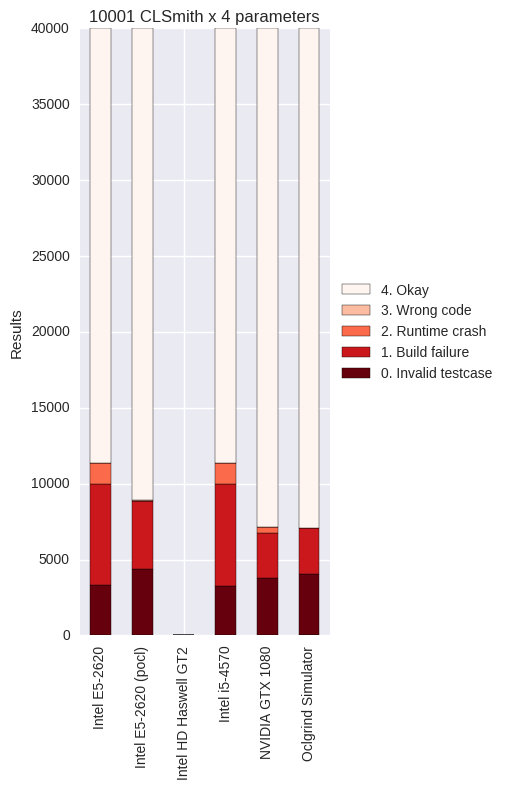

In [14]:
plot_outcomes(CLSmithResult, "CLSmith", dictname=classifications, key='Classification')

### CLSmith w. cldrive

In [15]:
outcomes["CLSmith w. cldrive"]

,Device,Outcome,Count,% of Device Results
0,NVIDIA GTX 1080,Unsupported Program,32899,82.239276
1,NVIDIA GTX 1080,Preprocessing Failed,5311,13.276172
2,NVIDIA GTX 1080,z_Okay,1655,4.137086
3,NVIDIA GTX 1080,No OpenCL kernel,64,0.159984
4,NVIDIA GTX 1080,cldrive Error,56,0.139986
5,NVIDIA GTX 1080,Timeout,12,0.029997
6,NVIDIA GTX 1080,clWaitForEvents(),3,0.007499
7,NVIDIA GTX 1080,CL_OUT_OF_HOST_MEMORY,3,0.007499
8,NVIDIA GTX 1080,Segmentation Fault,1,0.002500
9,Intel E5-2620,Unsupported Program,37940,94.840516


In [16]:
summarize('CLSmith w. cldrive')

,Platform,Device,Driver,Valid Testcases,Build Failures,Runtime Crashes,Incorrect Outputs,Okay
1,Intel(R) OpenCL,Intel E5-2620,1.2.0.25,1910,0.3% (6),4.8% (92),0.7% (14),94.1% (1798)
2,POCL,Intel E5-2620 (pocl),0.14,0,0,0,0,0
3,Intel(R) OpenCL,Intel i5-4570,1.2.0.25,0,0,0,0,0
4,NVIDIA CUDA,NVIDIA GTX 1080,375.39,1662,0.1% (1),0.4% (6),0.8% (14),98.7% (1641)
5,Oclgrind,Oclgrind Simulator,16.10,31,0,0,0,100.0% (31)


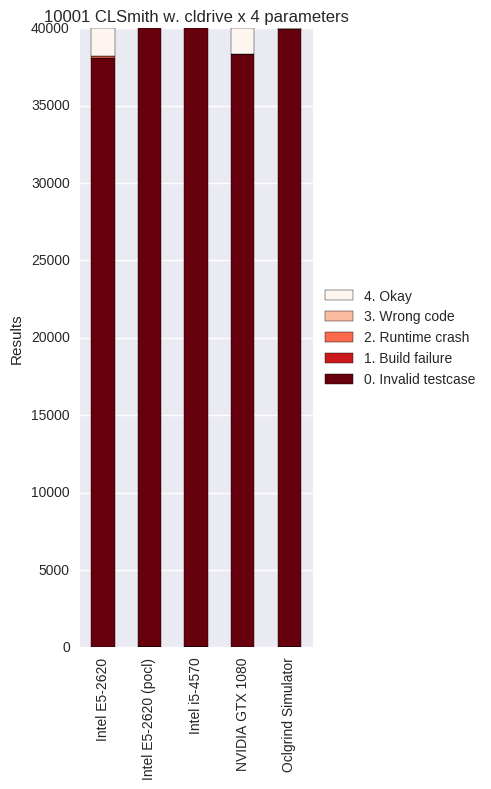

In [17]:
plot_outcomes(cldriveCLSmithResult, "CLSmith w. cldrive", dictname=classifications, key='Classification')

### GitHub

In [18]:
outcomes["GitHub"]

,Device,Outcome,Count,% of Device Results
0,NVIDIA GTX 1080,Unsupported Program,17594,37.081375
1,NVIDIA GTX 1080,z_Okay,10019,21.116193
2,NVIDIA GTX 1080,cldrive Error,6816,14.365503
3,NVIDIA GTX 1080,Multiple OpenCL kernels,5330,11.233587
4,NVIDIA GTX 1080,No OpenCL kernel,5018,10.576011
5,NVIDIA GTX 1080,clWaitForEvents(),1502,3.165637
6,NVIDIA GTX 1080,Preprocessing Failed,726,1.530128
7,NVIDIA GTX 1080,INVALID_WORK_GROUP_SIZE,369,0.777710
8,NVIDIA GTX 1080,Timeout,68,0.143318
9,NVIDIA GTX 1080,CL_OUT_OF_HOST_MEMORY,3,0.006323


In [19]:
summarize('GitHub')

Counting objects: 5, done.
Delta compression using up to 4 threads.
Compressing objects: 100% (4/4), done.
Writing objects: 100% (5/5), 488 bytes | 0 bytes/s, done.
Total 5 (delta 3), reused 0 (delta 0)
remote: Resolving deltas: 100% (3/3)
remote: Updating references: 100% (1/1)
To https://git.overleaf.com/8608915dsywxshwwjmw
   f49c609..81f32ba  master -> master


,Platform,Device,Driver,Valid Testcases,Build Failures,Runtime Crashes,Incorrect Outputs,Okay
1,Intel(R) OpenCL,Intel E5-2620,1.2.0.25,9600,14.6% (1401),0.3% (32),10.6% (1020),74.4% (7147)
2,POCL,Intel E5-2620 (pocl),0.14,11531,13.5% (1551),12.5% (1440),10.0% (1156),64.0% (7384)
3,Intel(R) OpenCL,Intel i5-4570,1.2.0.25,2403,4.7% (112),0.4% (9),5.3% (128),89.6% (2154)
4,NVIDIA CUDA,NVIDIA GTX 1080,375.39,11526,0.0% (2),13.1% (1505),8.4% (966),78.5% (9053)
5,Oclgrind,Oclgrind Simulator,16.10,0,0,0,0,0


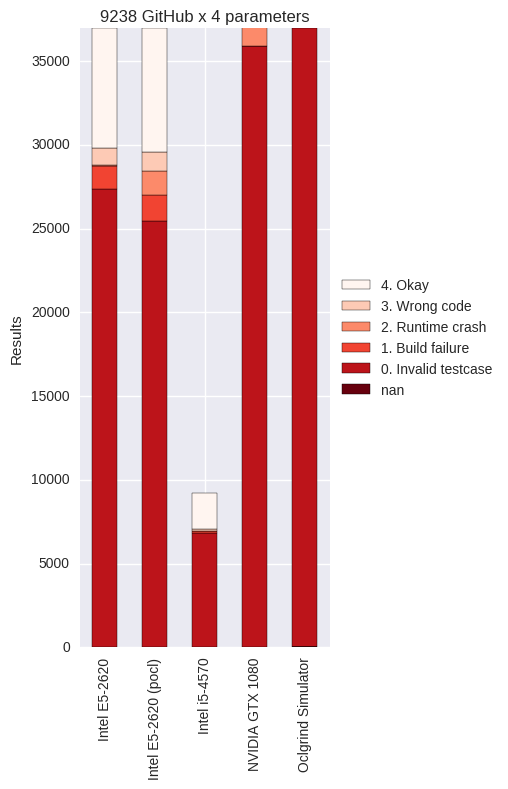

In [20]:
plot_outcomes(GitHubResult, "GitHub", dictname=classifications, key='Classification')

### CLgen

In [21]:
outcomes["CLgen"]

,Device,Outcome,Count,% of Device Results
0,NVIDIA GTX 1080,z_Okay,3994,99.850
1,NVIDIA GTX 1080,clWaitForEvents(),6,0.150
2,Intel E5-2620,z_Okay,3984,99.600
3,Intel E5-2620,Segmentation Fault,16,0.400
4,Intel i5-4570,z_Okay,3918,97.950
5,Intel i5-4570,Segmentation Fault,82,2.050
6,Oclgrind Simulator,z_Okay,3998,99.950
7,Oclgrind Simulator,cldrive Error,2,0.050
8,Intel E5-2620 (pocl),z_Okay,3984,99.600
9,Intel E5-2620 (pocl),cldrive.driver.PorcelainError: 1,6,0.150


In [22]:
summarize('CLgen')

,Platform,Device,Driver,Valid Testcases,Build Failures,Runtime Crashes,Incorrect Outputs,Okay
1,Intel(R) OpenCL,Intel E5-2620,1.2.0.25,4000,0.4% (16),0,15.0% (600),84.6% (3384)
2,POCL,Intel E5-2620 (pocl),0.14,3997,0.1% (3),0.3% (10),11.8% (470),87.9% (3514)
3,Intel(R) OpenCL,Intel i5-4570,1.2.0.25,4000,2.1% (82),0,11.8% (470),86.2% (3448)
4,NVIDIA CUDA,NVIDIA GTX 1080,375.39,4000,0,0.1% (6),18.7% (747),81.2% (3247)
5,Oclgrind,Oclgrind Simulator,16.10,3998,0,0,15.3% (611),84.7% (3387)


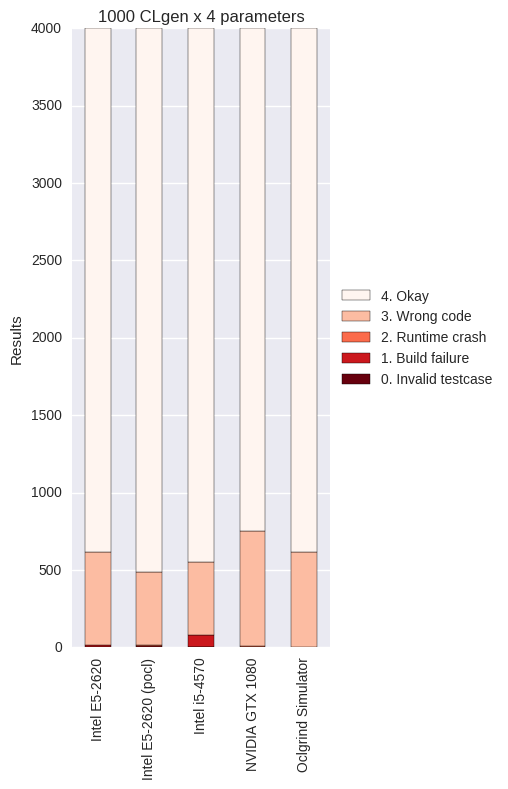

In [23]:
plot_outcomes(CLgenResult, "CLgen", dictname=classifications, key='Classification')

In [24]:
# TODO: GpuVERIFY

# from clgen import preprocess as clgen

# try:
#     clgen.gpuverify("__kernel void A() {}", ["--local_size=64", "--num_groups=128"])
#     gpuverified = True
# except clgen.GPUVerifyException:
#     gpuverified = False
    
# print(gpuverified)

End of experiments.